# HW12 Reinforcement Learning

# Preliminary work

## Install Packages

In [ ]:
!apt update
!apt install python3-opengl xvfb -y
!apt install -q swig
!pip install gym[box2d] pyvirtualdisplay tqdm

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,898 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,356 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricte

## Set up Virtual displayer

In [ ]:
# Store the output of this cell into variable 'captured_output' instead of
#   printing out.
%%capture captured_output
from pyvirtualdisplay import Display
virtual_display = Display(visible=False, size=(1400, 900))
virtual_display.start()


# Environment and Seed

In [ ]:
import gym
import random
import torch
import numpy as np


def create_env(env_name):
    return gym.make(env_name)

def fix_seed(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Random Agent Test

state : [-0.58822834 -0.15364479 -0.2321027   0.03562564  0.7191407   0.660152
  0.          1.        ], <class 'numpy.ndarray'>
reward : -100
done : True
else info :
{'TimeLimit.truncated': False}


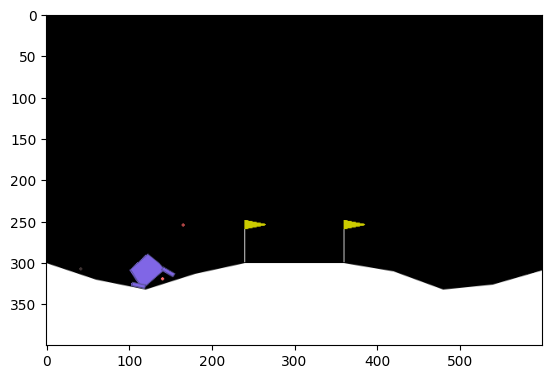

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display


# Create environment
env = create_env('LunarLander-v2')
fix_seed(env, 2024)

# Initial environment
initial_state = env.reset()

# Create an figure
img = plt.imshow(env.render(mode='rgb_array'))

# Start to play
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    # Update figure
    img.set_data(env.render(mode='rgb_array'))
    # Get the figure to display, that is, img.
    display.display(plt.gcf())
    # Clear output when new figure arrived.
    display.clear_output(wait=True)

print(f"state : {state}, {type(state)}")
print(f"reward : {reward}")
print(f"done : {done}")
print(f"else info :\n{_}")
# Release resources
del env, img

# Model

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical


class PolicyGradientNetwork(nn.Module):
    """
    Input : observation/state, a numpy array with length 8.
    """
    def __init__(self, in_dim, out_dim, ff_dim):
        super().__init__()

        def linear_tanh(in_dim, out_dim):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.Tanh()
            )

        self.fc = nn.Sequential(
            linear_tanh(in_dim, ff_dim),
            linear_tanh(ff_dim, ff_dim)
        )
        self.out_layer = nn.Linear(ff_dim, out_dim)

    def forward(self, state):
        hid = self.fc(state)
        out = self.out_layer(hid)
        return F.softmax(out, dim=-1)


class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=1e-3)

    def sample(self, state):
        """
        Sample an action based on input state.

        Return:
        action, and the corresponding log-probability
        """
        action_prob = self.network(torch.FloatTensor(state))
        action_dict = Categorical(action_prob)
        action = action_dict.sample()
        # return log(action-probability) for recording
        log_prob = action_dict.log_prob(action)
        return action.item(), log_prob

    def learn(self, log_probs, rewards):
        """
        Update parameters.
        """
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, PATH):
        agent_dict = {
            'network' : self.network.state_dict(),
            'optimizer' : self.optimizer.state_dict()
        }
        torch.save(agent_dict, PATH)

    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint['network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])

def create_agent(in_dim=8, out_dim=4, ff_dim=16):
    network = PolicyGradientNetwork(in_dim, out_dim, ff_dim)
    agent = PolicyGradientAgent(network)
    return agent


# Train

## Accumulative Decaying Reward

In [ ]:
def cal_adr(seq_rewards, decay_rate=0.99):
    """Calculate accumulative decaying reward."""
    adr = []
    n = len(seq_rewards)
    for i in range(n):
        reward = 0.0
        p_rate = 1.0
        for j in range(n-i):
            reward += seq_rewards[i+j] * (p_rate)
            p_rate *= decay_rate
        adr.append(reward)
    return adr

## Main

  0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


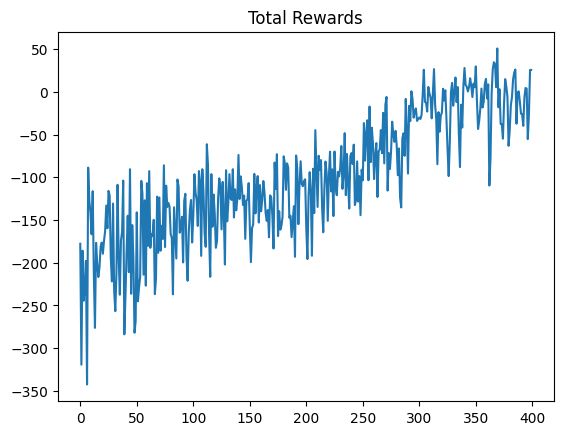

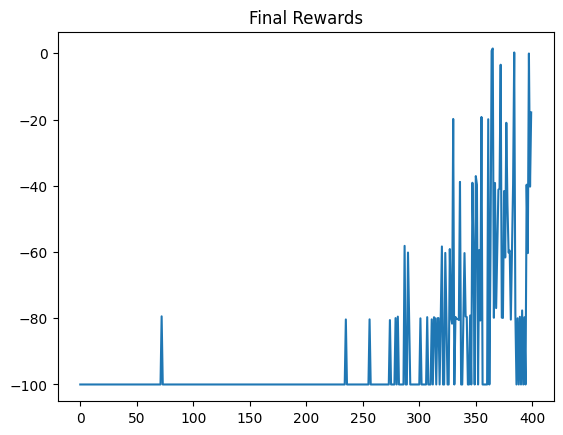

In [ ]:
import torch
from tqdm.notebook import tqdm


def parse_args():
    config = {
        'num_batch' : 400,
        'episodes_per_batch' : 5,
        'env_name' : 'LunarLander-v2',
        'seed' : 2021,
        'decay_rate' : 0.99,
    }
    return config

def main(
    num_batch,
    episodes_per_batch,
    env_name,
    seed,
    decay_rate,

):
    # environment
    env = create_env(env_name)
    fix_seed(env, seed)

    # model
    agent = create_agent()
    agent.network.train()

    # recordings
    avg_total_rewards, avg_final_rewards = [], []

    prg_bar = tqdm(range(num_batch))
    for batch in prg_bar:

        log_probs, rewards = [], []
        total_rewards, final_rewards = [], []

        # collect training data(trajectories)
        for episode in range(episodes_per_batch):

            state = env.reset()
            total_reward, total_step = 0.0, 0
            seq_rewards = []

            while True:
                action, log_prob = agent.sample(state)
                next_state, reward, done, _ = env.step(action)

                log_probs.append(log_prob)
                seq_rewards.append(reward)
                #rewards.append(reward)

                state = next_state
                total_reward += reward
                total_step += 1

                if done:
                    total_rewards.append(total_reward)
                    final_rewards.append(reward)
                    # Accumulative decaying reward(e.g. decay rate = 0.99)
                    #   action list : a1                              , a2
                    #   reward list : r1 + 0.99^1*r2 + 0.99^2*r3 + ..., r2 + 0.99^1*r3 + 0.99^2*r4 + ...
                    rewards += cal_adr(seq_rewards, decay_rate)
                    break

        # logging
        avg_total_reward = sum(total_rewards) / len(total_rewards)
        avg_final_reward = sum(final_rewards) / len(final_rewards)
        avg_total_rewards.append(avg_total_reward)
        avg_final_rewards.append(avg_final_reward)
        prg_bar.set_description(
            f"Total reward: {avg_total_reward:4.1f} | Final reward: {avg_final_reward:4.1f}"
        )

        # update model
        rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9) # normalization
        #print(torch.stack(log_probs), rewards)
        agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

    # plot result
    plt.plot(avg_total_rewards)
    plt.title('Total Rewards')
    plt.show()

    plt.plot(avg_final_rewards)
    plt.title("Final Rewards")
    plt.show()


if __name__ == '__main__':
    main(**parse_args())